In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Field Definitions
- step: is a timestep, each timestep is 0.25 seconds
- spool: is the integral of material feedrate from the beginning of the production. This is proportional to the mass of the total fiber extruded.
- diameter: is in 10e-5 meter
- speed: is mapped between 0 and 100
- motorV: is the PWM dutycycle of the motor and it's mapped between 0 and 100
- extfrq: is the frequency of the feeding extruder, which corresponds to the feedrate of the material
- temp: is the temperture of the heating chamber
- rests of the columns can be ignored for now

- Explore = Train Data; Exploit = Test Data

In [130]:
filenames = {
    'explore0':'2019_08_20_14_38.txt',
    'explore1':'2019_09_09_09_54.txt',
    'exploit0':'2019_08_20_15_36.txt',
    'exploit1':'2019_08_20_16_31.txt',
    'exploit2':'2019_08_20_17_06.txt', 
    'exploit3':'2019_08_21_13_04.txt',
    'exploit4':'2019_08_21_13_44.txt',
    'exploit5':'2019_08_21_16_19.txt'
}
columns = ['step', 'spool', 'diameter', 'speed', 'motorV', 'extfrq', 'target', 'greedy_m', 'greedy_e', 
           'reward', 'Q_exam', 'am_exam', 'a_exam', 'unk', 'temp']

# Create dict of dataframes
data = {}
for key in filenames:
    df = pd.read_csv('data/'+filenames[key], header=0, names=columns)
    df.reset_index(inplace=True, drop=True)
    df = df.drop(['unk', 'Q_exam', 'am_exam', 'a_exam', 'greedy_m', 'greedy_e', 'reward', 'step'], axis=1)
    for col in df.columns:
        df[col] = df[col].str.split(':').apply(lambda x: x[1])
    df = df.apply(pd.to_numeric)
    
    # Split dfs where 'spool' resets to zero
    last_split = 0
    for n,i in enumerate(split_idx):
        df_run = df[last_split:i]
        if len(df_run) > 0:
            data[key+'_'+str(n)] = df_run.reset_index(drop=True)
        last_split = i
        
data_keys = list(data.keys())
print('# of keys in data: ', len(data_keys))
print(data_keys)

# of keys in data:  14
['explore0_1', 'explore0_2', 'explore0_3', 'explore1_1', 'explore1_2', 'explore1_3', 'exploit0_1', 'exploit1_1', 'exploit1_2', 'exploit2_1', 'exploit2_2', 'exploit3_1', 'exploit4_1', 'exploit5_1']


In [131]:
data[data_keys[9]]

,spool,diameter,speed,motorV,extfrq,target,temp
0,0.00,35.7,80.72,23.70,18.71,33.1,80.036
1,0.01,35.3,81.04,24.49,19.24,33.1,80.174
2,0.03,35.6,78.00,26.18,20.28,33.1,80.139
3,0.05,32.7,66.48,28.99,21.94,33.1,80.139
4,0.06,33.8,57.60,32.93,24.32,33.1,80.174
...,...,...,...,...,...,...,...
2688,98.04,41.4,92.48,89.10,83.47,41.4,80.105
2689,98.08,42.9,92.56,89.23,83.39,41.4,80.002
2690,98.12,42.9,92.72,89.42,83.36,41.4,80.139
2691,98.16,45.1,92.48,89.62,83.37,41.4,80.208


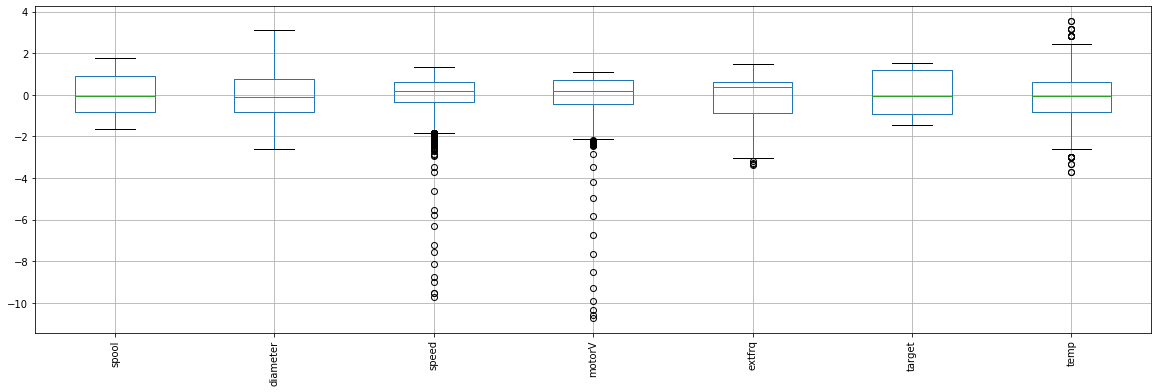

In [40]:
df_z = df.drop(['step'], axis = 1)
cols = df_z.columns
for col in cols:
    df_z[col] = (df_z[col] - df_z[col].mean())/df_z[col].std(ddof=0)

df_z.boxplot(figsize=(20,6), rot=90)

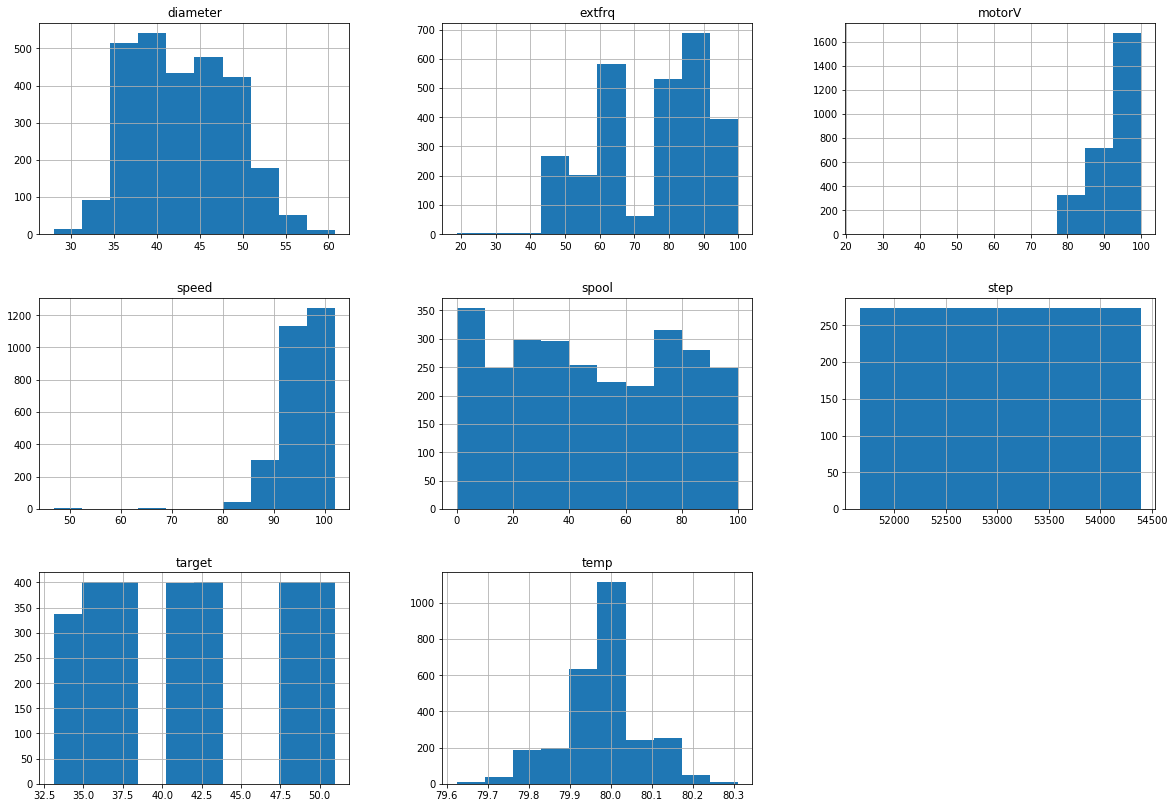

In [41]:
hist = df.hist(figsize=(20,14))

[Text(0.5, 0, 'step'),
 Text(1.5, 0, 'spool'),
 Text(2.5, 0, 'diameter'),
 Text(3.5, 0, 'speed'),
 Text(4.5, 0, 'motorV'),
 Text(5.5, 0, 'extfrq'),
 Text(6.5, 0, 'target'),
 Text(7.5, 0, 'temp')]

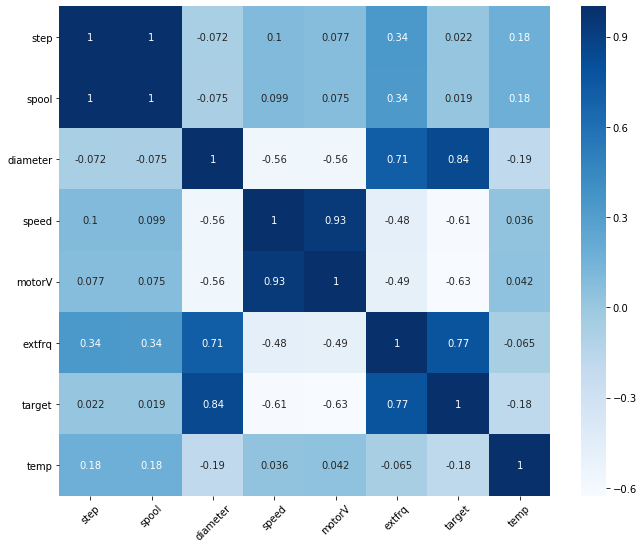

In [42]:
# Correlation Plot
f, ax = plt.subplots(figsize=(11, 9))
cor = df.corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

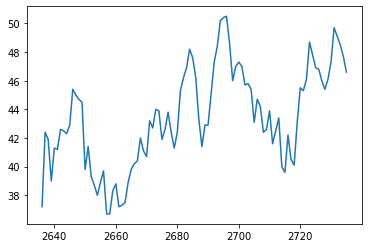

In [43]:
x = 0
y = df['diameter'][-100:]
plt.plot(y)